In [1]:
import os, sys

import IPython.display as ipd

path= '/Users/sbielfel/Nextcloud2/time_resolved/'
sys.path.append(path)
path= '/Users/sbielfel/Nextcloud2/phase_retrieval/algos/'
sys.path.append(path)
%load_ext autoreload
%autoreload 2

In [2]:
print(sys.executable)

/Users/sbielfel/anaconda3/envs/fml/bin/python


In [3]:
# import h5py
import meteor
import reciprocalspaceship as rs
import numpy as np
import gemmi 
import ipywidgets as widgets
from scipy.ndimage import gaussian_filter
# from output_eval import *

In [4]:
from occupancy import *
from plotting3d import *

In [5]:
%matplotlib ipympl
%matplotlib inline

In [6]:
variant = "basic"
noise_level=0
plotfolder = "./plots/"

# Remarks
Rework of previous dataset. The analysis is highly similar compared to the other notebook. I created gifs for the more important 3d plots. There are no major surprises compared to the other notebook (anymore).

In [7]:

mtzloc = "../X8X8_test_1"
name_dark = "k.mtz"
name_light = "on.mtz"
ds_light = rs.read_mtz(dataloc+name_light)
ds_dark = rs.read_mtz(dataloc+name_dark)

NameError: name 'dataloc' is not defined

In [8]:

dataloc = "../synthetic_cistrans/"
match variant:
    case "basic":
        name_dark = "trans_sf.mtz"
        name_light = "100ps_sf.mtz"
        alpha = 0.27
    case "basic-alt":
        name_dark = "trans_sf.mtz"
        name_light = "100ps_sfV2.mtz"
        alpha = 0.27
    case "noise":
        name_light = "100ps_withSIGFC_amplitudenoise.mtz"
        name_dark = "trans_withSIGFC_amplitudenoise.mtz"
        alpha = 0.27
ds_light = rs.read_mtz(dataloc+name_light)
ds_dark = rs.read_mtz(dataloc+name_dark)

In [9]:
ds_dark["sf"] = ds_dark.to_structurefactor("FC", "PHIC")
f_dark = ds_dark.to_reciprocal_grid("sf")
ds_light["sf"] = ds_light.to_structurefactor("FC", "PHIC")
f_light = ds_light.to_reciprocal_grid("sf")
delta_fa_abs = np.abs(f_light)-np.abs(f_dark)

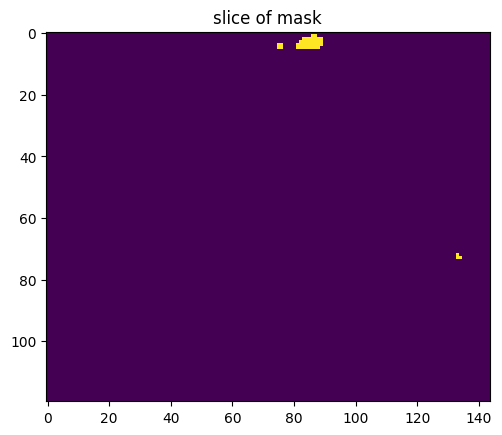

In [10]:
# flipped compared to normal order!!!
# np.flip(obj, (0,1,2)) to adjust
f_light_0 = np.abs(f_light)*np.exp(1j*np.angle(f_dark))
obj1 = np.real(np.fft.ifftn(f_light_0))
obj0 = np.real(np.fft.ifftn(f_dark))

obj_mix = alpha*obj1+(1-alpha)*obj0
delta_obj = obj1-obj0

mask_pks = gaussian_filter(np.abs(delta_obj),1)>0.01
plt.figure()
plt.imshow(mask_pks[7])
plt.title("slice of mask")
plt.show()

In [11]:
pdbname_light = dataloc+"100ps.pdb"
struc_light = gemmi.read_structure(pdbname_light)
pdbname_dark = dataloc + "trans.pdb"
struc_dark = gemmi.read_structure(pdbname_dark)

pos_list = np.array([(rca.atom.pos).tolist()   for rca in struc_light[0].all()])
for idx in range(3):
    diff = np.max(pos_list[:,idx])-np.min(pos_list[:,idx])


Text(0.5, 0, 'Occupancy')

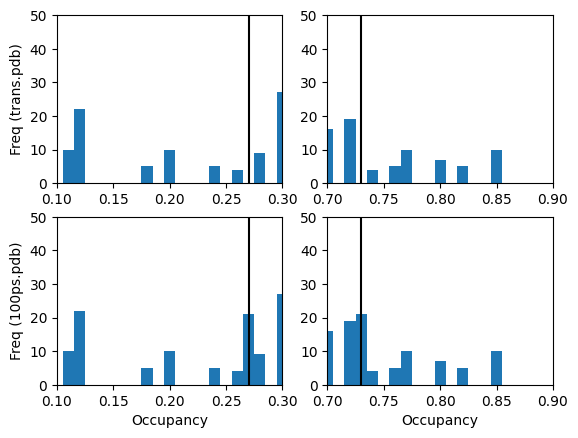

In [12]:
plt.close("all")
fig, axs = plt.subplots(2,2)
ax =axs[0,0]
bins = np.linspace(0.005,1.005,101)
for ax in axs.flat:
    ax.axvline(alpha,color="k")
    ax.axvline(1-alpha,color="k")
    ax.set_ylim(0,50)
    
ax =axs[0,0]
ax.hist([np.round(x.atom.occ,2) for x in struc_dark[0].all()], bins = bins)
ax.set_xlim(.1,.3)
ax.set_ylabel("Freq (trans.pdb)")

ax =axs[1,0]
ax.hist([np.round(x.atom.occ,2) for x in struc_light[0].all()], bins = bins)
ax.set_xlim(.1,.3)
ax.set_ylabel("Freq (100ps.pdb)")
ax.set_xlabel("Occupancy")

ax =axs[0,1]
ax.hist([np.round(x.atom.occ,2) for x in struc_dark[0].all()], bins = bins)
ax.set_xlim(.7,.9)

ax =axs[1,1]
ax.hist([np.round(x.atom.occ,2) for x in struc_light[0].all()], bins = bins)
ax.set_xlim(.7,.9)
ax.set_xlabel("Occupancy")


basically I am just checking that the occupancies are where you promised them to be - and that nothing else occupies this occupancy range.

interactive(children=(IntSlider(value=0, description='f0', max=99), Output()), _dom_classes=('widget-interact'…

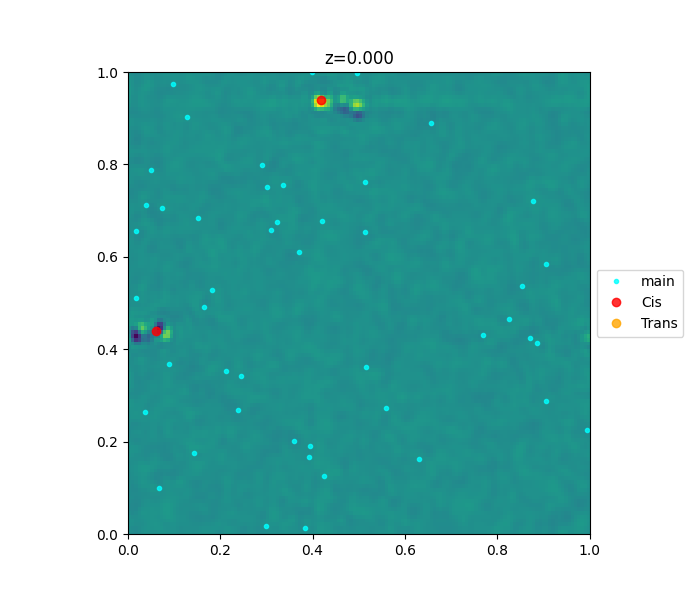

In [114]:

from plotting3d import get_pos_from_pdb
frac_list, occ_mask=get_pos_from_pdb(struc_light, search_occ=0.27)
%matplotlib widget
if True:
    mtz_comp(frac_list,occ_mask,  np.flip(obj1-obj0,(0,1,2)),extent=[0,1,1,0]) 
else:
    mtz_comp(frac_list,occ_mask,  np.flip(obj1,(0,1,2)),extent=[0,1,1,0], gif_name="gifs/match_pdbmtz.gif")



In [14]:
# slice_3d(np.flip(obj1-obj0,(0,1,2))[32:58, 50:76, 65:90])

In [15]:
obj1.shape

(100, 120, 144)

Making sure that I understand the data and a way to find alternative conformations

interactive(children=(IntSlider(value=0, description='f0', max=99), Output()), _dom_classes=('widget-interact'…

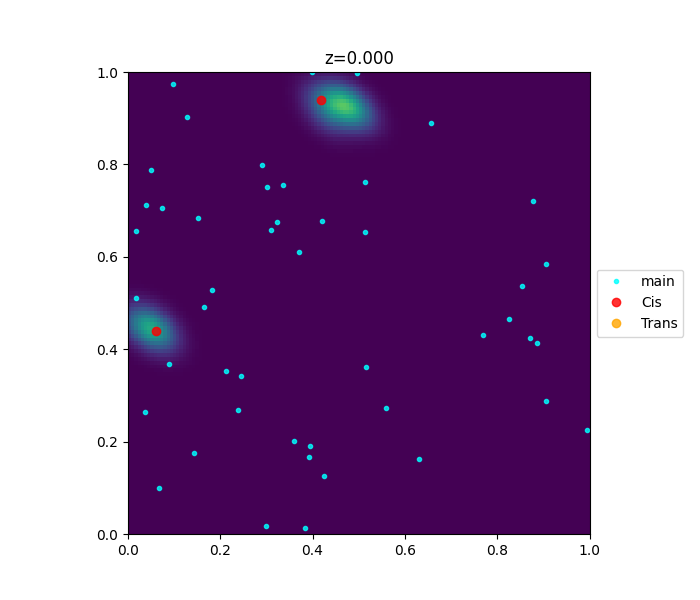

In [29]:
from scipy import stats
def make_blurred(frac_pos, grid_shape,radius= .01):
    frac_pos = frac_pos.T
    X, Y, Z = np.mgrid[
        0 : 1 : grid_shape[0] * 1j,
        0 : 1 : grid_shape[1] * 1j,
        0 : 1 : grid_shape[2] * 1j,
    ]
    grid = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])

    kernel = stats.gaussian_kde(frac_pos, radius)
    density = np.reshape(kernel(grid).T, X.shape)
    return density
out = make_blurred(frac_list[occ_mask>0],obj1.shape, radius=0.1)

vv = "mtz_style"
match vv:
    case "normal":
        extent = [0,1,1,0]
        mtz_comp(frac_list,occ_mask, out, extent=extent)
    case "mtz_style":
        extent = [1,0,0,1]
        out = np.flip(out,(0,1,2))
        mtz_comp(frac_list,occ_mask, out[::-1], extent=extent)


curiously the ordering was a bit fidely.

## Angle Approximation Check
Should be lower than 0.25

In [17]:
np.round(np.sum(np.abs(delta_fa_abs)) / np.sum(np.abs(f_dark)),3)

np.float64(0.026)

# Start of the actual analysis

In [18]:
alpha_xtrs = np.linspace(0,1,20)+1e-10
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=2, noise_level = 0)
corr_x8 = x8_inspired(np.abs(f_dark),np.abs(f_light), np.abs(f_xtrs))

Easier than my above attempt is of course to just calculate the difference of the two phased objects.

interactive(children=(IntSlider(value=0, description='f0', max=99), Output()), _dom_classes=('widget-interact'…

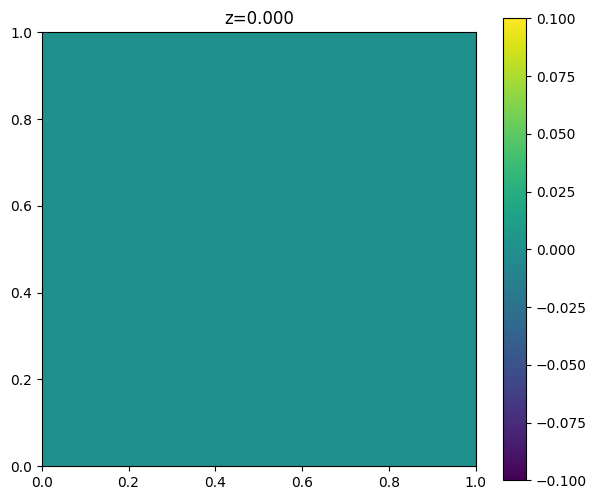

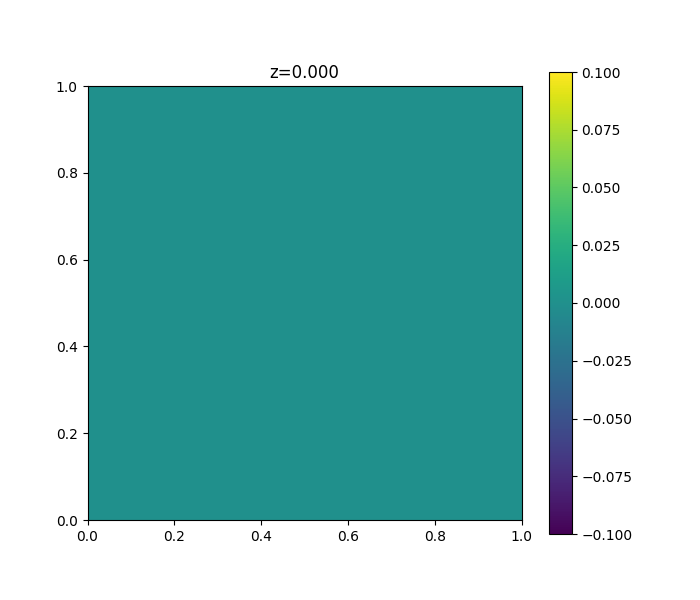

In [113]:
mask_pks_filt = gaussian_filter(np.array(mask_pks,float), 1)>.2
# %matplotlib inline
slice_3d(mask_pks_filt+np.array(mask_pks,float))

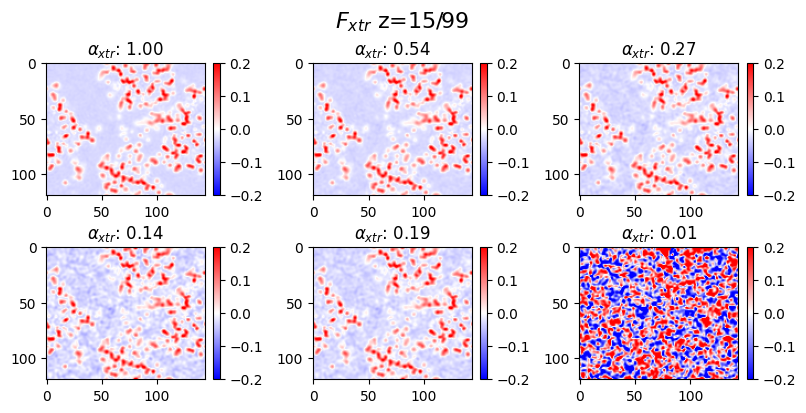

interactive(children=(IntSlider(value=15, description='f0', max=99), Output()), _dom_classes=('widget-interact…

In [20]:
    
alphax = 0.27
alpha_xtrs_vis = np.array([1, alphax*2, alphax, alphax/2,0.19, 0.01])
f_xtrs = make_f_xtr(alpha_xtrs_vis, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
dens_xtrs, neg_sum = marius(f_xtrs)
    
from plotting3d import show_xtrs
%matplotlib inline
anim = show_xtrs(dens_xtrs, alpha_xtrs_vis, obj0, alpha, version="only", variant=variant, make_gif=False)


In [21]:
%matplotlib inline
if False:
    for version in ["only", "diff", "diffnorm" , "diffxtr"]:
        anim = show_xtrs(dens_xtrs, alpha_xtrs_vis, obj0, alpha, 
                         version=version, variant=variant, make_gif=True)
        


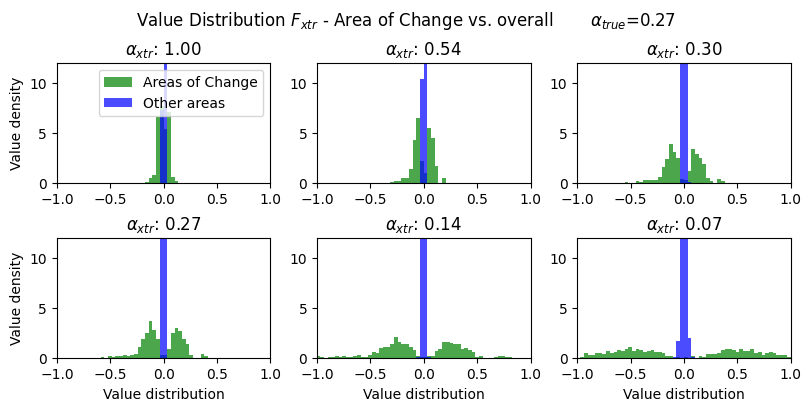

In [22]:
def show_hist():
    alphax = 0.27
    alpha_xtrs_vis = np.array([1, alphax*2, 0.3, alphax, alphax/2,alphax/4])
    f_xtrs = make_f_xtr(alpha_xtrs_vis, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
    dens_xtrs, neg_sum = marius(f_xtrs)
    fig, axs = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
    ims = []
    for ax, alpha_xtr, arr in zip(axs.flat, alpha_xtrs_vis,dens_xtrs):
        raw = [r"$\alpha_{xtr}$",
               r"$\alpha_t$"]
        tit = f"{raw[0]}: {alpha_xtr:.2f}"
        ax.set_title(tit)
        ax.set_ylim(0,12)
        ax.set_xlim(-1,1)
        bins = np.linspace(np.min(arr), np.max(arr), 30)
        bins = np.linspace(np.min(dens_xtrs), np.max(dens_xtrs), 100)
        arr = arr-obj0
        ax.hist(arr[mask_pks],color="green", alpha=0.7, density=True, bins= bins, label="Areas of Change")
        ax.hist(arr[~mask_pks], color = "blue", alpha=0.7, density=True, bins= bins, label = "Other areas")
        # fig.suptitle(title + f" z={f0}/{imlen-1}", fontsize=16)    
    axs[0,0].legend()
    for ax in [axs[0,0],axs[1,0]]:
        ax.set_ylabel("Value density")
    for ax in axs[1]:
        ax.set_xlabel("Value distribution")
    fig.suptitle("Value Distribution $F_{xtr}$ - Area of Change vs. overall \t"
                 + r"$\alpha_{true}$="+str(alpha))
show_hist()


In [93]:
alpha_invs = (np.arange(0,20)+1e-10)
alpha_xtrs = 2/alpha_invs
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level = 0)
dens_xtrs, neg_sum = marius(f_xtrs)
from occupancy import marius_masked


0.27


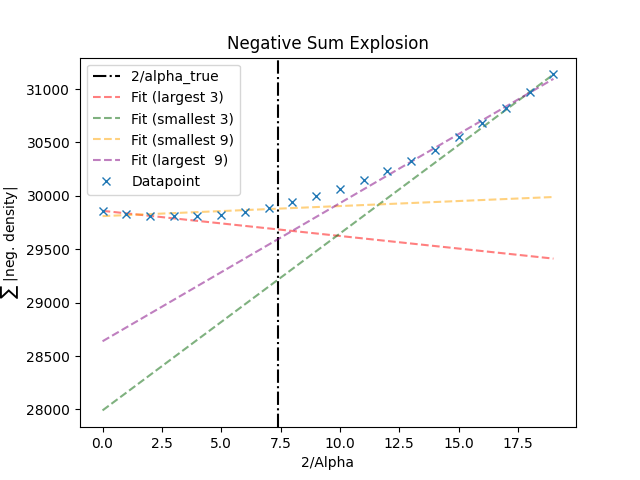

In [66]:
from scipy import stats
n_largest = 3
n_more = 9
def get_fits(neg_sum, alpha_invs, n_largest):
    m_lowest = alpha_invs>alpha_invs[-n_largest]
    m_biggest = alpha_invs<alpha_invs[n_largest]
    res_lowest = stats.linregress(alpha_invs[m_lowest], -neg_sum[m_lowest])
    res_biggest = stats.linregress(alpha_invs[m_biggest], -neg_sum[m_biggest])
    alpha_line = np.linspace(np.min(alpha_invs), np.max(alpha_invs),5,)
    fit_lowest =  res_lowest.intercept+res_lowest.slope*alpha_line
    fit_biggest =  res_biggest.intercept+res_biggest.slope*alpha_line
    return  alpha_line, fit_lowest, fit_biggest    
alpha_line, fit_biggest1, fit_lowest1 = get_fits(neg_sum, alpha_invs, n_largest)
_         , fit_biggest2, fit_lowest2 = get_fits(neg_sum, alpha_invs, n_more)

fig = plt.figure()
plt.axvline(2/alpha,c="k",linestyle="-.", label="2/alpha_true")
kwargs = {
"linestyle":"--",
"alpha": 0.5,
}
plt.plot(alpha_line, fit_lowest1, **kwargs, c="red",        label=f"Fit (largest {n_largest})")
plt.plot(alpha_line, fit_biggest1,**kwargs, c="darkgreen",  label=f"Fit (smallest {n_largest})")
plt.plot(alpha_line, fit_lowest2, **kwargs, c="orange",     label=f"Fit (smallest {n_more})")
plt.plot(alpha_line, fit_biggest2,**kwargs, c="purple",     label=f"Fit (largest  {n_more})")
plt.plot(alpha_invs,neg_sum*-1, "x",  label="Datapoint")
plt.legend()
print(alpha)
plt.xlabel("2/Alpha")
plt.ylabel(r"$\sum$ |neg. density|")
plt.title("Negative Sum Explosion")
from plotting3d import fname_variant
loc = plotfolder+fname_variant(variant)
fig.savefig(loc + "_negsumexplosion.png")

interactive(children=(IntSlider(value=0, description='f0', max=99), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntSlider(value=0, description='f0', max=99), Output()), _dom_classes=('widget-interact'…

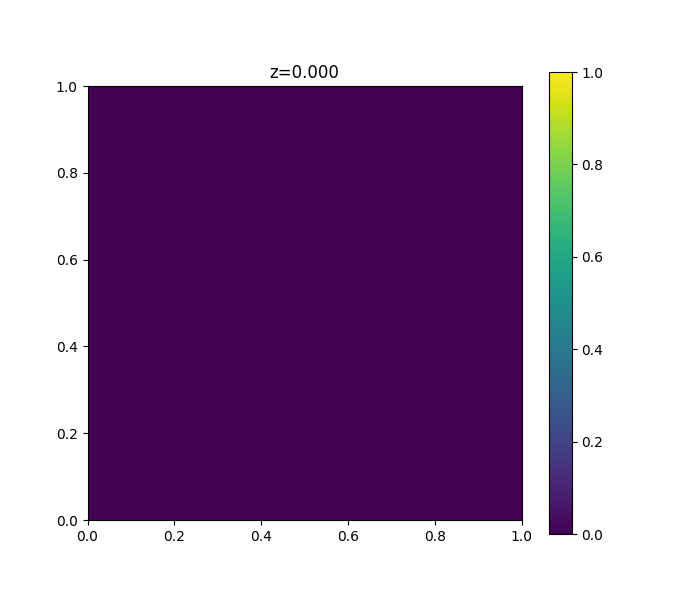

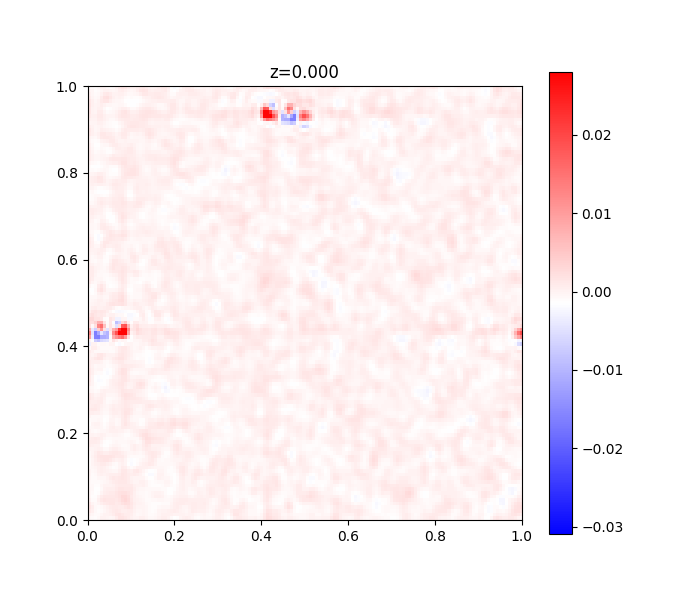

In [103]:
# fig = slice_3d(mask_pks_strict_neg, imkwargs={"alpha":.5},)
fig = slice_3d(mask_pks_strict_neg, imkwargs={"alpha":1},)
_ = slice_3d(delta_obj, imkwargs={"cmap":"bwr", "alpha":.99}, fig=fig)


0.27


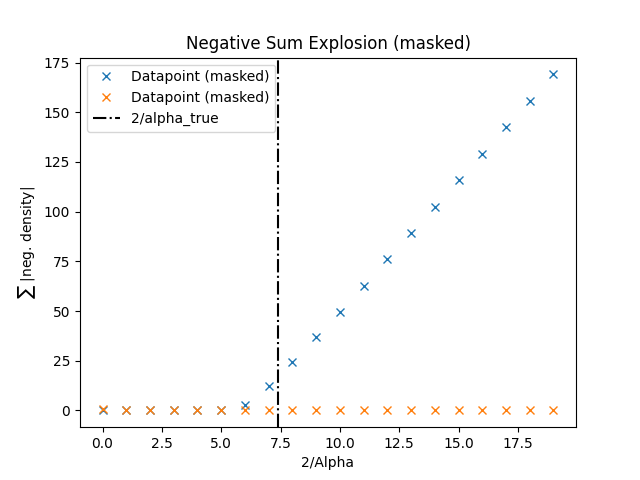

In [100]:

delta_obj = obj1-obj0
strict = 0.02
mask_pks_strict_abs = gaussian_filter(np.abs(delta_obj),1)>strict
mask_pks_strict_pos = gaussian_filter((delta_obj),1)>strict
mask_pks_strict_neg = gaussian_filter((delta_obj),1)<-strict
mask_pks_strict_neg = ((delta_obj))<-strict
_, neg_sum_msk_neg = marius_masked(f_xtrs, mask_pks_strict_neg)
_, neg_sum_msk_pos = marius_masked(f_xtrs, mask_pks_strict_pos)
alpha_line, fit_biggest1, fit_lowest1 = get_fits(neg_sum_msk, alpha_invs, n_largest)
_         , fit_biggest2, fit_lowest2 = get_fits(neg_sum_msk, alpha_invs, n_more)
fig = plt.figure()
# plt.plot(alpha_invs,neg_sum_msk*-1, "x",  label="Datapoint (masked)")
plt.plot(alpha_invs,neg_sum_msk_neg*-1, "x",  label="Datapoint (masked)")
plt.plot(alpha_invs,neg_sum_msk_pos*-1, "x",  label="Datapoint (masked)")
plt.axvline(2/alpha,c="k",linestyle="-.", label="2/alpha_true")
# plt.plot(alpha_line, fit_lowest1, c="red",linestyle="--", label=f"Fit (largest {n_largest})")
# plt.plot(alpha_line, fit_biggest1, c="darkgreen",linestyle="--",label=f"Fit (smallest {n_largest})")
# plt.plot(alpha_line, fit_lowest2, c="orange",linestyle="--", label=f"Fit (smallest {n_more})")
# plt.plot(alpha_line, fit_biggest2,  c="purple",linestyle="--", label=f"Fit (largest  {n_more})")
plt.legend()
print(alpha)
plt.xlabel("2/Alpha")
plt.ylabel(r"$\sum$ |neg. density|")
plt.title("Negative Sum Explosion (masked)")
from plotting3d import fname_variant
loc = plotfolder+fname_variant(variant)
# fig.savefig(loc + "_negsumexplosion.png")


In [104]:
2/5.8

0.3448275862068966

IndentationError: unexpected indent (2611559584.py, line 14)

interestingly, the results for this are better/more consistent with noise rather than without.

[0.27       0.20241808 0.34      ]


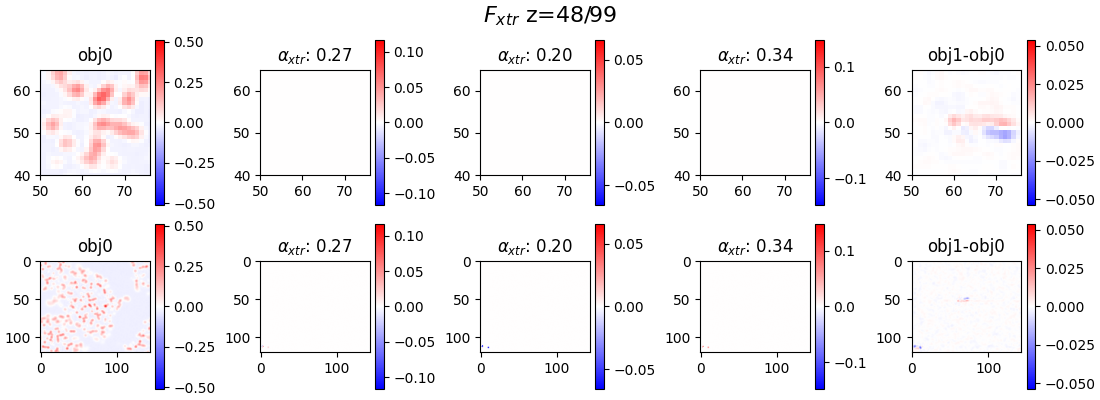

interactive(children=(IntSlider(value=48, description='f0', max=99), Output()), _dom_classes=('widget-interact…

In [105]:
# slice_3d(np.flip(obj1-obj0,(0,1,2))[32:58, 50:76, 65:90])
intersection = (res_2.intercept-res_1.intercept) / (res_1.slope-res_2.slope)
alpha_intersect = 2/intersection
intersection = (res_2.intercept-res_11.intercept) / (res_11.slope-res_2.slope)
alpha_intersect2 = 2/intersection

alpha_xtrs_vis = np.array([alpha ,alpha_intersect, 0.34])
f_xtrs = make_f_xtr(alpha_xtrs_vis, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
dens_xtrs, neg_sum = marius(f_xtrs)
print(alpha_xtrs_vis)
plt.close('all')
%matplotlib widget
anim = direct_comp(
    dens_xtrs*mask_pks_strict_neg,
    alpha_xtrs_vis,
    obj0,
    obj1,
    version="only",
    idx=48,
    make_gif=False
) 

In [46]:
from occupancy import  x8_density_map_fdiff_norm

alpha_xtrs = np.linspace(5e-2,1,100 )

f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
peak_sum, real_CC = x8_density_map_f1(f_xtrs, mask_pks, obj0, delta_obj)
peak_sum_diff, real_CC_diff = x8_density_map_fdiff(f_xtrs, mask_pks, obj0, delta_obj)
peak_sum_diffnorm, real_CC_diffnorm = x8_density_map_fdiff_norm(f_xtrs, mask_pks, obj0, delta_obj)

NameError: name 'peak_sum' is not defined

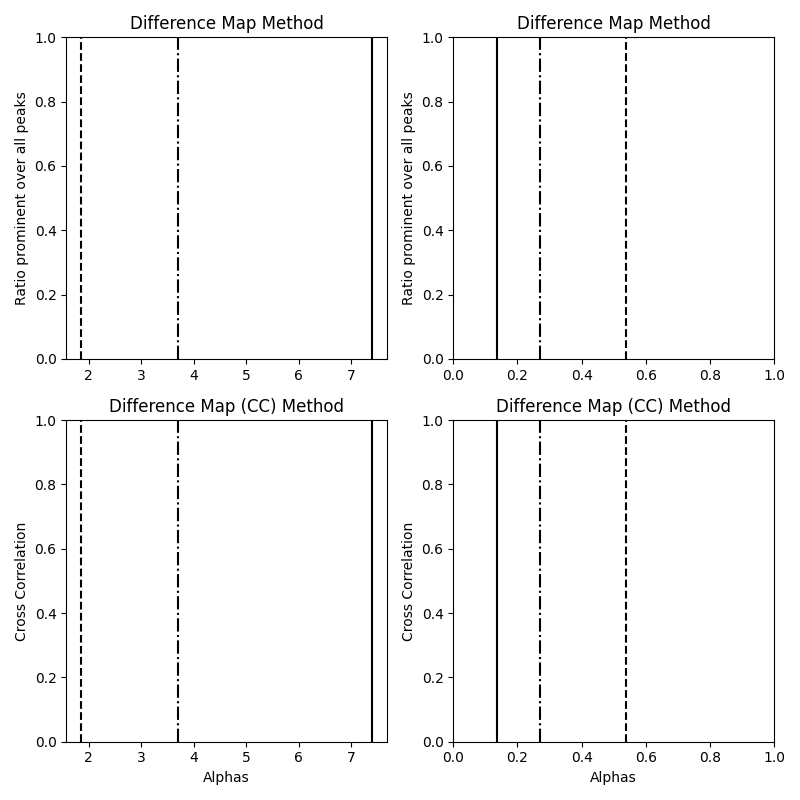

In [45]:
fig, axs = plt.subplots(2,2, figsize=(8,8),tight_layout=True)
for ax in axs[0] :
    ax.set_ylabel("Ratio prominent over all peaks")
    ax.set_title("Difference Map Method")
    
for ax in axs[:,0] :
    ax.axvline(1/(alpha/2),c="k", linestyle="-", label="alpha_true/2")
    ax.axvline(1/alpha,c="k", linestyle="-.", label="alpha_true")
    ax.axvline(1/(alpha*2),c="k", linestyle="--", label="2*alpha_true")
    
for ax in axs[:,1] :
    ax.axvline(alpha/2,c="k", linestyle="-", label="alpha_true/2")
    ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
    ax.axvline(alpha*2,c="k", linestyle="--", label="2*alpha_true")
    
for ax in axs[1] :
    ax.axhline(0,c="k", linewidth=.5, )
    ax.set_ylabel("Cross Correlation")
    ax.set_xlabel("Alphas")
    ax.set_title("Difference Map (CC) Method")

ax = axs[0,0]
ax.plot(1/alpha_xtrs,peak_sum, label=r"F_xtr",color="g")
ax.plot(1/alpha_xtrs,peak_sum_diff, label=r"F_xtr-F0",color="brown")
ax.plot(1/alpha_xtrs,peak_sum_diffnorm, label=r"norm(F_xtr)-norm(F0)",color="b")
ax.legend()

ax = axs[0,1]
ax.plot(alpha_xtrs,peak_sum, label=r"$\phi_{0}$",color="g")
ax.plot(alpha_xtrs,peak_sum_diff, label=r"$\phi_{0}$",color="brown")
ax.plot(alpha_xtrs,peak_sum_diffnorm, label=r"norm(F_xtr)-norm(F0)",color="b")

ax = axs[1,0]
ax.plot(1/alpha_xtrs,real_CC, label=r"$\phi_{0}$",color="g")
ax.plot(1/alpha_xtrs,real_CC_diff, label=r"F_xtr-F0",color="brown")
ax.plot(1/alpha_xtrs,real_CC_diffnorm, label=r"norm: F_xtr-F0",color="b")
ax.set_xlabel("1/occupancy")

ax = axs[1,1]
ax.plot(alpha_xtrs,real_CC,  label=r"F_xtr"    ,    color="g")
ax.plot(alpha_xtrs,real_CC_diff, label=r"F_xtr-F0",color="brown")
ax.plot(alpha_xtrs,real_CC_diffnorm, label=r"norm: F_xtr-F0",color="b")
ax.set_xlabel("occupancy")

loc = plotfolder+fname_variant(variant)
fig.savefig(loc + "_differencemap.png")

Text(0.5, 0, 'occupancy')

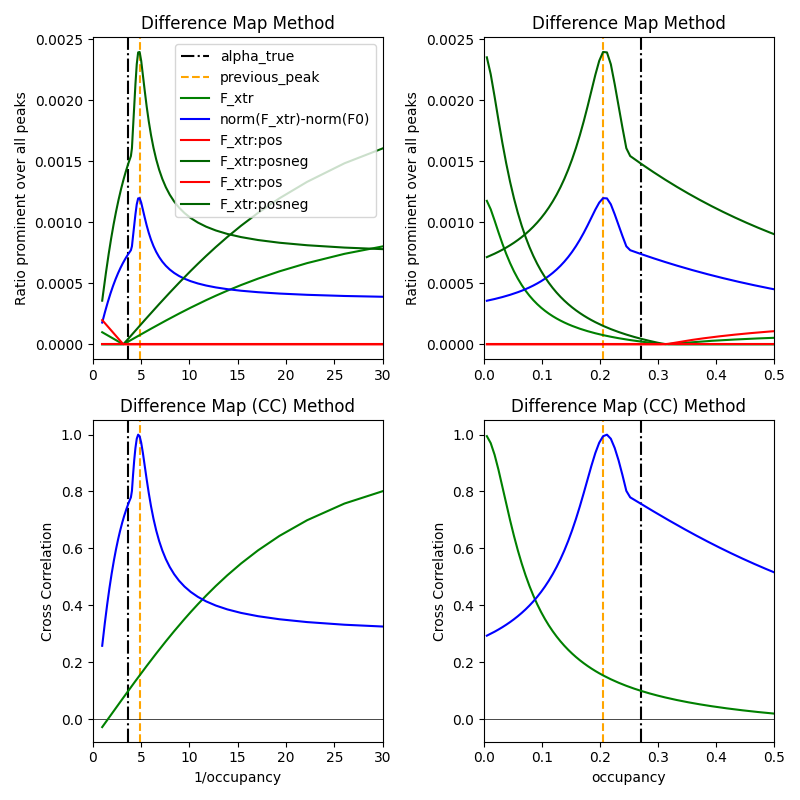

In [110]:
alpha_xtrs = np.linspace(5e-3,1,150 )

# f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
# peak_sum, real_CC, peak_pos, peak_neg = x8_density_map_f1(f_xtrs, mask_pks, obj0, delta_obj, posneg=True)
# # peak_sum_diffnorm, real_CC_diffnorm, fract = x8_density_map_fdiff_norm(f_xtrs, mask_pks, obj0, delta_obj, inspect=True)
# peak_sum_diffnorm, real_CC_diffnorm, peak_pos_diffnorm, peak_neg_diffnorm = x8_density_map_fdiff_norm(f_xtrs, mask_pks, obj0, delta_obj, posneg=True)

# peak_sum_difffact, real_CC_difffact = x8_density_map_fdiff_factor(f_xtrs/alpha_xtrs[:,None,None], mask_pks, obj0, delta_obj, 1)
# peak_sum_diff_noisyf0, real_CC_diff_noisyf0 = x8_density_map_fdiff_noisyf0(f_xtrs, mask_pks, obj0, delta_obj)

#print(np.max(),axis=(1,2)))

pk_val = alpha_xtrs[np.argmax(peak_sum_diffnorm)]

fig, axs = plt.subplots(2,2, figsize=(8,8),tight_layout=True)
for ax in axs[0] :
    ax.set_ylabel("Ratio prominent over all peaks")
    ax.set_title("Difference Map Method")
    
for ax in axs[:,0] :
    # ax.axvline(1/(alpha/2),c="k", linestyle="-", label="alpha_true/2")
    ax.axvline(1/alpha,c="k", linestyle="-.", label="alpha_true")
    # ax.axvline(1/(alpha*2),c="k", linestyle="--", label="2*alpha_true")
    ax.axvline(1/pk_val,c="orange", linestyle="--", label="previous_peak")
    ax.set_xlim(0,30)
    
for ax in axs[:,1] :
    # ax.axvline(alpha/2,c="k", linestyle="-", label="alpha_true")
    ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
    # ax.axvline(alpha*2,c="k", linestyle="--", label="2*alpha_true")
    ax.axvline(pk_val,c="orange", linestyle="--", )
    ax.set_xlim(0,0.5)
    
for ax in axs[1] :
    ax.axhline(0,c="k", linewidth=.5, )
    ax.set_ylabel("Cross Correlation")
    ax.set_xlabel("Alphas")
    ax.set_title("Difference Map (CC) Method")

ax = axs[0,0]
ax.plot(1/alpha_xtrs,peak_sum, label=r"F_xtr",color="g")
ax.plot(1/alpha_xtrs,peak_sum_diffnorm, label=r"norm(F_xtr)-norm(F0)",color="b")
ax.plot(1/alpha_xtrs,peak_pos, label=r"F_xtr:pos",color="red")
ax.plot(1/alpha_xtrs,peak_neg, label=r"F_xtr:posneg",color="darkgreen")
ax.plot(1/alpha_xtrs,peak_pos_diffnorm, label=r"F_xtr:pos",color="red")
ax.plot(1/alpha_xtrs,peak_neg_diffnorm, label=r"F_xtr:posneg",color="darkgreen")
# ax.plot(1/alpha_xtrs,peak_sum_diff_noisyf0, label=r"norm(F_xtr)-norm(F0)",color="r")
# ax.plot(1/alpha_xtrs,peak_sum_difffact, label=r"norm(F_xtr)-norm(F0)",color="cyan")
ax.legend()

ax = axs[0,1]
ax.plot(alpha_xtrs,peak_sum, label=r"$\phi_{0}$",color="g")
# ax.plot(alpha_xtrs,peak_sum_diff, label=r"$\phi_{0}$",color="brown")
ax.plot(alpha_xtrs,peak_sum_diffnorm, label=r"norm(F_xtr)-norm(F0)",color="b")
ax.plot(alpha_xtrs,peak_pos, label=r"F_xtr:pos",color="red")
ax.plot(alpha_xtrs,peak_neg, label=r"F_xtr:posneg",color="darkgreen")
ax.plot(alpha_xtrs,peak_pos_diffnorm, label=r"F_xtr:pos",color="red")
ax.plot(alpha_xtrs,peak_neg_diffnorm, label=r"F_xtr:posneg",color="darkgreen")
# ax.plot(alpha_xtrs,peak_sum_diff_noisyf0, label=r"norm(F_xtr)-norm(F0)",color="r")
# ax.plot(alpha_xtrs,peak_sum_difffact, label=r"norm(F_xtr)-norm(F0)",color="cyan")

ax = axs[1,0]
ax.plot(1/alpha_xtrs,real_CC, label=r"$\phi_{0}$",color="g")
# ax.plot(1/alpha_xtrs,real_CC_diff, label=r"F_xtr-F0",color="brown")
ax.plot(1/alpha_xtrs,real_CC_diffnorm, label=r"norm: F_xtr-F0",color="b")
# ax.plot(1/alpha_xtrs,real_CC_diff_noisyf0, label=r"norm: F_xtr-F0",color="r")
# ax.plot(1/alpha_xtrs,real_CC_difffact, label=r"norm: F_xtr-F0",color="cyan")
ax.set_xlabel("1/occupancy")

ax = axs[1,1]
ax.plot(alpha_xtrs,real_CC,  label=r"F_xtr"    ,    color="g")
# ax.plot(alpha_xtrs,real_CC_diff, label=r"F_xtr-F0",color="brown")
ax.plot(alpha_xtrs,real_CC_diffnorm, label=r"norm: F_xtr-F0",color="b")
# ax.plot(alpha_xtrs,real_CC_diff_noisyf0, label=r"norm: F_xtr-F0",color="r")
# ax.plot(alpha_xtrs,real_CC_difffact, label=r"norm: F_xtr-F0",color="cyan")
ax.set_xlabel("occupancy")


I think I said quite a bit about it in the previous text. Here I don't have much to add.

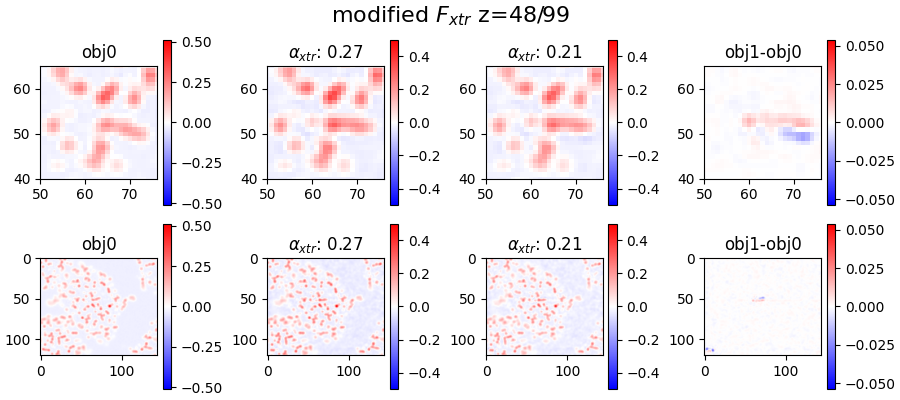

interactive(children=(IntSlider(value=48, description='f0', max=99), Output()), _dom_classes=('widget-interact…

In [47]:
pk_val = alpha_xtrs[np.argmax(peak_sum_diffnorm)]
pk_val

alpha_xtrs_vis = np.array([alpha,pk_val])
f_xtrs = make_f_xtr(alpha_xtrs_vis, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
dens_xtrs, neg_sum = marius(f_xtrs)

direct_comp(
    dens_xtrs,
    alpha_xtrs_vis,
    obj0,
    obj1,
    version="diffxtr",
    variant=variant,
    # make_gif=True,
    idx=48,
) 


<string>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


interactive(children=(IntSlider(value=0, description='f0', max=99), Output()), _dom_classes=('widget-interact'…

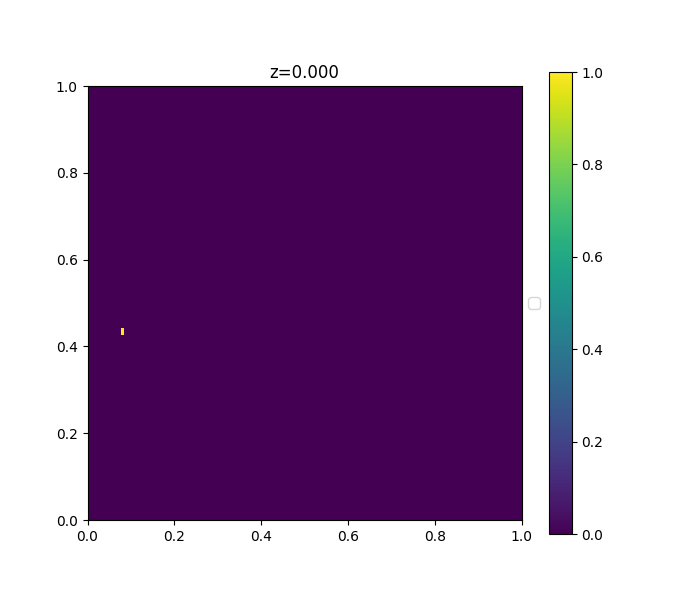

In [48]:
delta_obj = obj1-obj0
strict = 0.02
lax = 0.005
mask_pks = gaussian_filter(np.abs(delta_obj),1)>0.01
mask_pks_strict = gaussian_filter(np.abs(delta_obj),1)>strict
mask_pks_lax = gaussian_filter(np.abs(delta_obj),1)>lax
mask_pks_filt = gaussian_filter(np.array(mask_pks,float), 1)>.9
mask_pks = np.abs(delta_obj)>0.06
# slice_3d(delta_obj, cmap='bwr',vmin=-np.max(delta_obj), vmax=np.max(delta_obj))
slice_3d(mask_pks_strict)
# ([delta_obj,mask_pks_filt],rows=1, cols=2)


In [ ]:
bins = np.logspace(-6,0,100)
bins = np.concatenate([[0], bins])
plt.figure()
plt.hist(delta_obj.flatten(),bins=bins)
plt.axvline(strict, label="narrow", color="r")
plt.axvline(lax, label="wide", color='g')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Value Distribution $\Delta \rho$")
plt.ylabel("Frequency")

In [ ]:
alpha_xtrs = np.linspace(5e-2,1,50 )

f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
mean_local_strict, mean_global_strict = pandda(f_dark, f_xtrs, mask_pks)
mean_local_lax, mean_global_lax = pandda(f_dark, f_xtrs, mask_pks_lax)


In [ ]:
mean_local, mean_global =  mean_local_strict, mean_global_strict
# mean_local, mean_global =  mean_local_lax, mean_global_lax
ml = [mean_local_strict, mean_local_lax]
mg = [mean_global_strict, mean_global_lax]
titles = ["narrow mask", "wide mask"]

fig, axso = plt.subplots(3,2)
for axs, mean_local, mean_global, title in zip(axso.T, ml, mg, titles):
    ax = axs[0]
    ax.set_title(title)
    ax.axvline(alpha,c="k", linestyle="-.", )
    ax.plot(alpha_xtrs,+mean_global-mean_local, label="global-local") 
    ax.legend()
    ax = axs[1]
    ax.axvline(alpha,c="k", linestyle="-.", )
    ax.axhline(0,c="k", linestyle="--")
    ax.plot(alpha_xtrs,mean_local, label="local") 
    ax.plot(alpha_xtrs, mean_global,label="global")
    ax.legend()
    ax = axs[2]
    # ax.axvline(alpha/2,c="k", linestyle="-", label="1/2*alpha_true")
    ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
    # ax.axvline(alpha*2,c="k", linestyle="--", label="2*alpha_true")
    ax.plot(alpha_xtrs,+np.gradient(mean_global-mean_local), label="global-local") 
    ax.legend()

fig.suptitle("PanDDA method")
loc = plotfolder+fname_variant(variant)
fig.savefig(loc + "_pandda.png")

Here, too, results look better for the case of noise. Weird. That is assuming one knows the most crucial regions of change.

Also, here it is far from 0 correlation at the correct occupancy. This makes the underlying assumption motivation seam rather brittle.

In [ ]:
pk_strict = alpha_xtrs[np.argmax(mean_global_strict-mean_local_strict)]
pk_lax = alpha_xtrs[np.argmax(mean_global_lax-mean_local_lax)]

alpha_xtrs_vis = np.array([alpha,pk_lax, pk_strict])
f_xtrs = make_f_xtr(alpha_xtrs_vis, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
dens_xtrs, neg_sum = marius(f_xtrs)

direct_comp(
    dens_xtrs,
    alpha_xtrs_vis,
    obj0,
    obj1,
    version="only",
    variant=variant,
    idx=48,
    make_gif = False
) 
